# SHAP Analysis Guide

## Set-up

In [1]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import warnings

In [2]:
plt.style.use("style.mplstyle")
shap.initjs()

## Prepare Data, Model, and SHAP Values

### Load Data

- [Dataset original paper](https://www.law.berkeley.edu/files/Hedonic.PDF)
- [Issues with 'R' variable](https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8)

In [3]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    boston = load_boston()
    X = pd.DataFrame(
        boston.data,
        columns=[
            "crime rate",
            "% residential zone",
            "% industrial zone",
            "Charles River",
            "NOX concentration",
            "number of rooms",
            "% built before 1940",
            "remoteness",
            "connectedness",
            "tax rate",
            "pupil-teacher ratio",
            "B",
            "% working class"
        ],
    ).drop("B", axis=1)
    X["% working class"] = X["% working class"] * 2
    y = boston.target * 1000
    df = X.copy()
    df["y"] = y
X.head()

,crime rate,% residential zone,% industrial zone,Charles River,NOX concentration,number of rooms,% built before 1940,remoteness,connectedness,tax rate,pupil-teacher ratio,% working class
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,9.96
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,18.28
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,8.06
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,5.88
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,10.66


In [4]:
df.to_csv("data/data.csv", index=False)

In [5]:
df.describe().astype(int)

,crime rate,% residential zone,% industrial zone,Charles River,NOX concentration,number of rooms,% built before 1940,remoteness,connectedness,tax rate,pupil-teacher ratio,% working class,y
count,506,506,506,506,506,506,506,506,506,506,506,506,506
mean,3,11,11,0,0,6,68,3,9,408,18,25,22532
std,8,23,6,0,0,0,28,2,8,168,2,14,9197
min,0,0,0,0,0,3,2,1,1,187,12,3,5000
25%,0,0,5,0,0,5,45,2,4,279,17,13,17025
50%,0,0,9,0,0,6,77,3,5,330,19,22,21200
75%,3,12,18,0,0,6,94,5,24,666,20,33,25000
max,88,100,27,1,0,8,100,12,24,711,22,75,50000


FixedFormatter should only be used together with FixedLocator


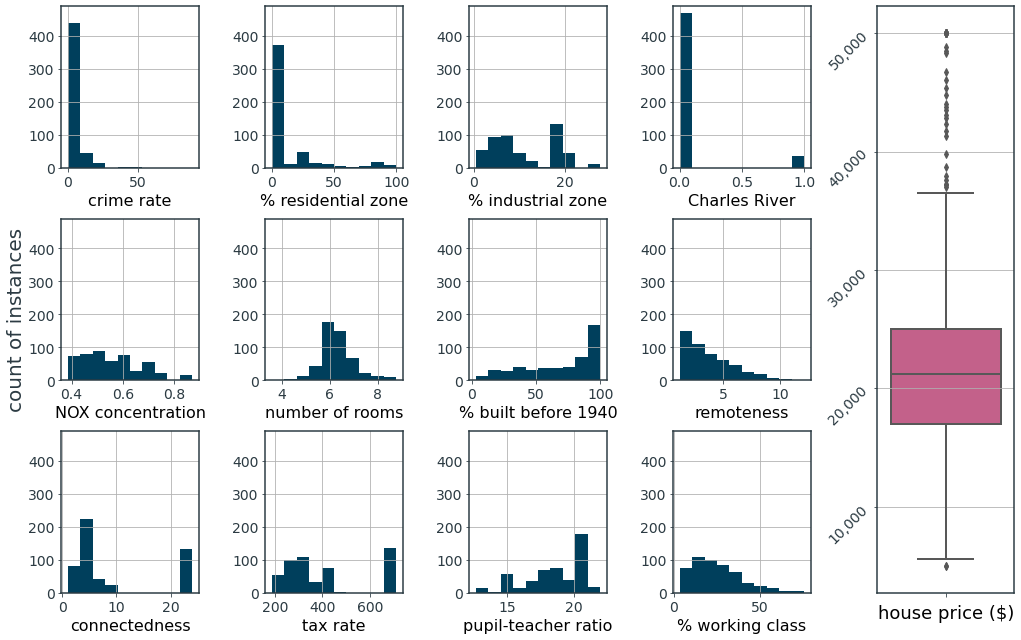

In [6]:
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(14, 9))
gs = axs[1, 2].get_gridspec()
# remove the underlying axes
for ax in axs[:, -1]:
    ax.remove()
axbig = fig.add_subplot(gs[:, -1])
axs = axs.flatten()

for col, i in zip(X.columns, [0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13]):
    axs[i].hist(X[col])
    axs[i].set_xlabel(col, size=16)
    axs[i].grid()
    axs[i].set_ylim(0, 490)

d = df.copy()
d["house price"] = df["y"]
# d[["house price"]].boxplot(ax=axbig, notch=True, patch_artist=True)
sns.boxplot(y=d["house price"], color="#d45087")
axbig.set_yticklabels(axbig.get_yticks(), rotation=45)
axbig.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ","))
)
axbig.set_xlabel("house price ($)")
axbig.set_ylabel("")
axbig.grid(axis="y")

fig.subplots_adjust(hspace=0.5)
fig.text(-0.01, 0.5, "count of instances", va="center", rotation="vertical", size=20)
fig.tight_layout()
fig.savefig("plots/data.png")

### Train Model

In [7]:
m = lgb.LGBMRegressor()
m.fit(X, y)

LGBMRegressor()

In [8]:
y_pred = m.predict(X)

from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y, y_pred, squared=False)
rmse

1310.1544628922263

### Compute SHAP Values

In [9]:
explainer = shap.Explainer(m)
shap_values = explainer(X)

In [10]:
explainer.expected_value

22532.8063239976

In [11]:
np.mean(y)

22532.806324110672

## SHAP Analysis

### Local

In [12]:
i_med = np.argsort(y_pred)[len(y_pred)//2]
i_max = np.argmax(y_pred)
i_80 = np.argsort(y_pred)[int(len(y_pred)*0.8)]
i_60 = np.argsort(y_pred)[int(len(y_pred)*0.6)]
i_40 = np.argsort(y_pred)[int(len(y_pred)*0.4)]
i_20 = np.argsort(y_pred)[int(len(y_pred)*0.2)]
i_min = np.argmin(y_pred)

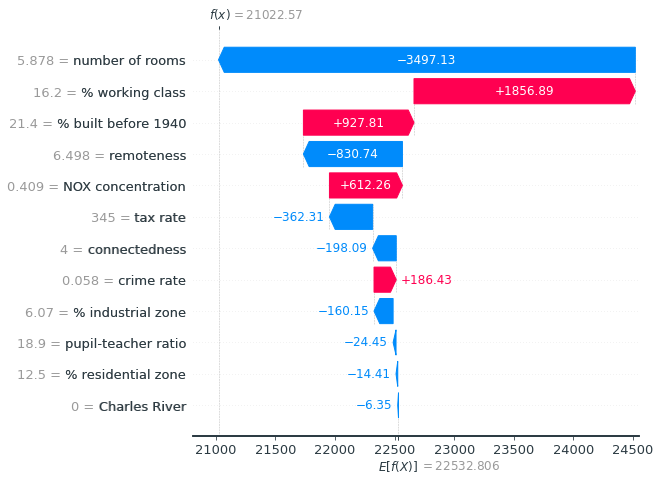

In [13]:
shap.plots.waterfall(shap_values[i_med], max_display=99, show=False)
plt.gcf()
plt.savefig("plots/waterfall.png")

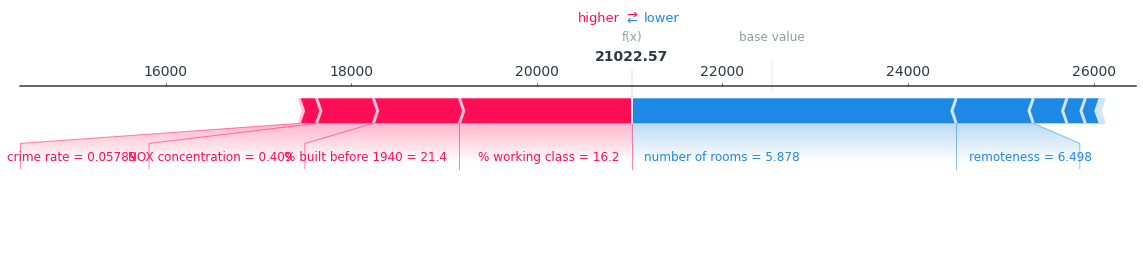

In [14]:
shap.plots.force(shap_values[i_med], show=False, matplotlib=True)
plt.gcf()
plt.savefig("plots/force_median.png")

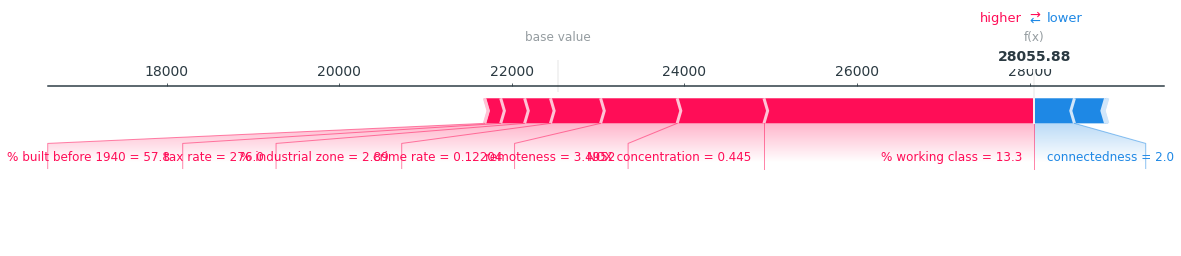

In [15]:
shap.plots.force(shap_values[i_80], show=False, matplotlib=True)
plt.gcf()
plt.savefig("plots/force_80.png")

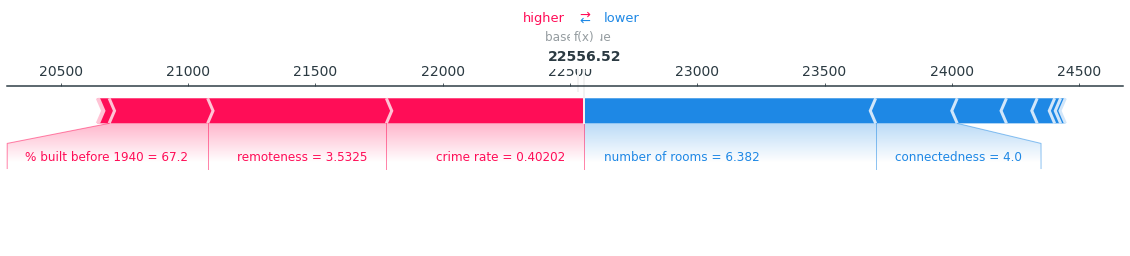

In [16]:
shap.plots.force(shap_values[i_60], show=False, matplotlib=True)
plt.gcf()
plt.savefig("plots/force_60.png")

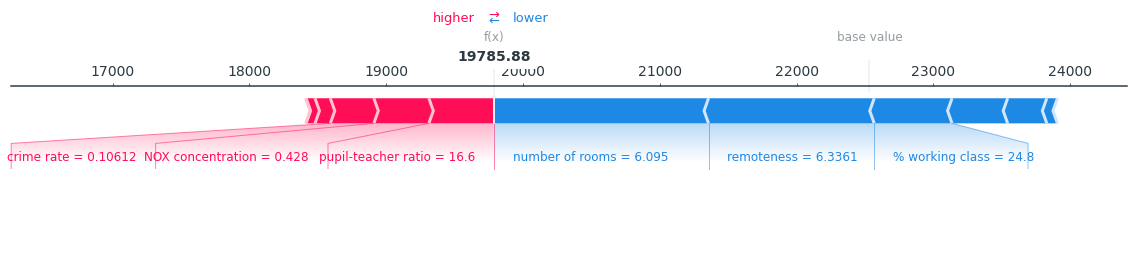

In [17]:
shap.plots.force(shap_values[i_40], show=False, matplotlib=True)
plt.gcf()
plt.savefig("plots/force_40.png")

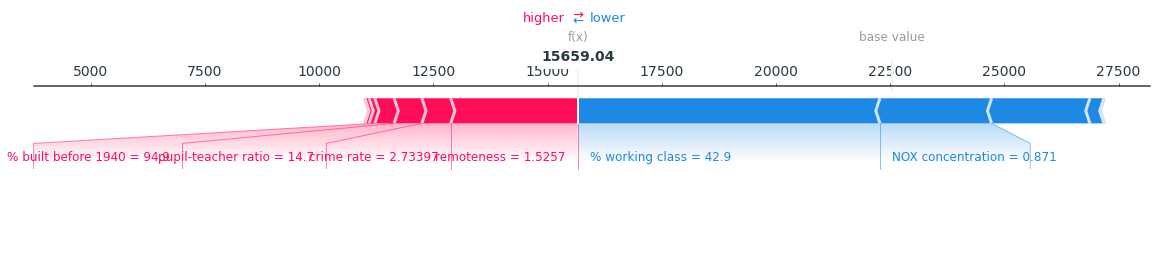

In [18]:
shap.plots.force(shap_values[i_20], show=False, matplotlib=True)
plt.gcf()
plt.savefig("plots/force_20.png")

### Global

#### Summary plots

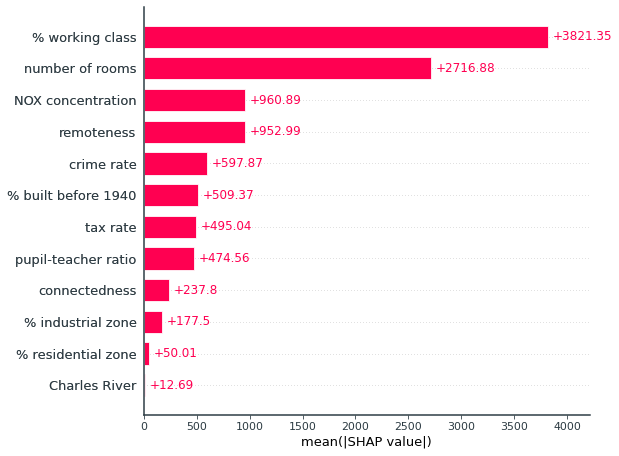

In [19]:
shap.plots.bar(shap_values, max_display=99, show=False)
plt.gcf()
plt.savefig("plots/bar.png")

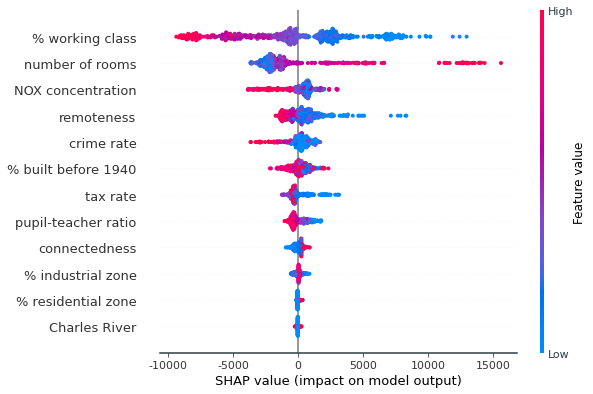

In [20]:
shap.plots.beeswarm(shap_values, max_display=99, show=False)
plt.gcf()
plt.savefig("plots/beeswarm.png")

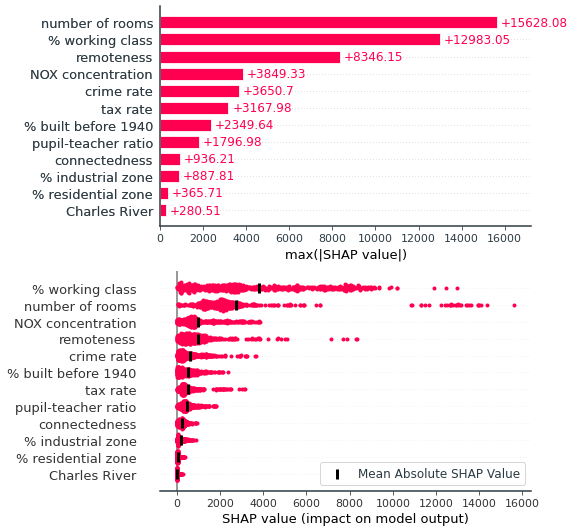

In [21]:
plt.subplot(2, 1, 1)
plt.gcf()
shap.plots.bar(shap_values.abs.max(0), max_display=99, show=False)
plt.subplot(2, 1, 2)
shap.plots.beeswarm(
    shap_values.abs, color="shap_red", max_display=99, show=False, plot_size=None
)
ax = plt.gca()
masv = {}
for feature in ax.get_yticklabels():
    name = feature.get_text()
    col_ind = X.columns.get_loc(name)
    mean_abs_sv = np.mean(np.abs(shap_values.values[:, col_ind]))
    masv[name] = mean_abs_sv
ax.scatter(
    masv.values(),
    [i for i in range(len(X.columns))],
    zorder=99,
    label="Mean Absolute SHAP Value",
    c="k",
    marker="|",
    linewidths=3,
    s=100,
)
ax.legend(frameon=True)
plt.tight_layout()
plt.savefig("plots/bar_beeswarm.png")

#### Dependence Plots

FixedFormatter should only be used together with FixedLocator


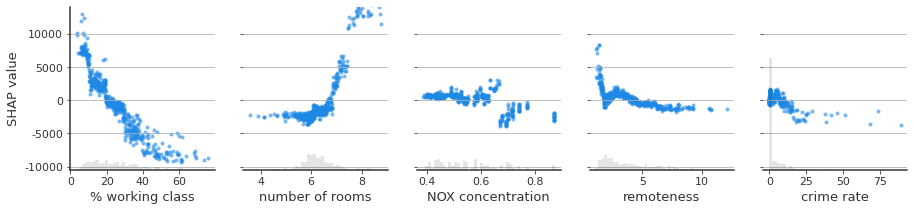

In [22]:
n = 5
fig, ax = plt.subplots(1, n, figsize=(15, 3))

for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
    if i < n:
        shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
        ax[i].grid(axis="y")
        if i != 0:
            ax[i].set_ylabel("")
            ax[i].spines["left"].set_visible(False)
            ax[i].set_ylim(ax[0].get_ylim())
            ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
        else:
            ax[i].set_ylabel("SHAP value")
fig.savefig("plots/scatter_top5.png")

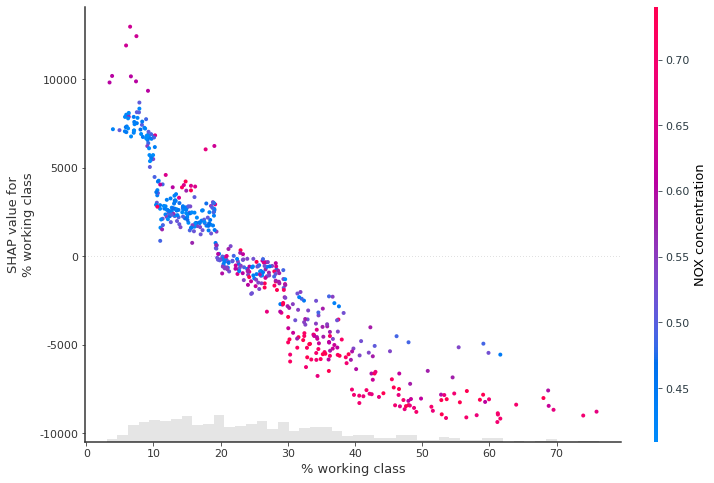

In [23]:
fig, ax = plt.subplots()
shap.plots.scatter(shap_values[:, "% working class"], color=shap_values, ax=ax)
fig.savefig("plots/scatter_coloured.png")